# TAML (Task Agnostic Meta Learning) on Omniglot

This notebook demonstrates how to train and evaluate TAML for 5-way 1-shot learning on Omniglot.

## What is TAML?

TAML (Task Agnostic Meta Learning) is a meta-learning algorithm that:
- Learns to adapt to new tasks by predicting **parameter modulations and learning rates**
- Uses a **shared CNN body** with detached features for robust encoding
- Uses an **encoder** to map detached features to latent codes
- Uses a **decoder** to generate parameter modulations and learning rates from latent codes
- Performs **gradient descent on modulated parameters** for fast adaptation

### Key Advantages:
1. **Efficient**: Learns both modulations and learning rates in latent space
2. **Effective**: Excellent performance on few-shot learning
3. **Flexible**: Four different modulation approaches (global, per-layer, broadcasting, low-rank)

### References:
- Based on latent embedding optimization approaches for meta-learning

## 1. Setup and Imports

In [1]:
import sys
sys.path.append('/mnt/c/meta-learning-from-scratch')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import TAML
from algorithms.taml import TaskAgnosticMetaLearning, train_taml

# Import Omniglot utilities
from utils.load_omniglot import OmniglotDataset, OmniglotTaskDataset, PrefetchedOmniglotDataset

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3070 Laptop GPU


## 2. Configuration

In [9]:
# Task configuration
N_WAY = 5          # 5-way classification
K_SHOT = 1         # 1-shot learning
NUM_QUERY = 15     # 15 query examples per class

# Training configuration
NUM_TRAIN_TASKS = 1500
NUM_TEST_TASKS = 100
BATCH_SIZE = 8

# TAML hyperparameters
LATENT_DIM = 64
MODULATION_APPROACH = 'per_layer_scalars'  # Options: 'global_scalars', 'per_layer_scalars', 'per_parameter_via_broadcasting', 'low_rank_factorization'
OUTER_LR = 0.001

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Configuration:")
print(f"  Task: {N_WAY}-way {K_SHOT}-shot")
print(f"  Query per class: {NUM_QUERY}")
print(f"  Training tasks: {NUM_TRAIN_TASKS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Latent dim: {LATENT_DIM}")
print(f"  Modulation approach: {MODULATION_APPROACH}")
print(f"  Outer LR: {OUTER_LR}")
print(f"  Device: {device}")

# Log device information
print(f"\nDevice Information:")
print(f"  Device type: {device.type}")
print(f"  Device index: {device.index if device.type == 'cuda' else 'N/A'}")
if device.type == 'cuda':
    print(f"  CUDA device name: {torch.cuda.get_device_name(device)}")
    print(f"  CUDA memory: {torch.cuda.get_device_properties(device).total_memory / 1024**3:.1f} GB")

Configuration:
  Task: 5-way 1-shot
  Query per class: 15
  Training tasks: 1500
  Batch size: 8
  Latent dim: 64
  Modulation approach: per_layer_scalars
  Outer LR: 0.001
  Device: cuda

Device Information:
  Device type: cuda
  Device index: None
  CUDA device name: NVIDIA GeForce RTX 3070 Laptop GPU
  CUDA memory: 8.0 GB


## 3. Load Omniglot Dataset

In [3]:
# Setup data path and create task dataset
data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_background"  # Update this path as needed
    
print("Loading Omniglot training dataset...")
train_dataset= PrefetchedOmniglotDataset(data_path)
test_dataset = PrefetchedOmniglotDataset(data_path.replace("images_background", "images_evaluation"))

Loading Omniglot training dataset...
🚀 Prefetching Omniglot dataset into RAM with multiprocessing...
   Using 16 worker processes
   This should take 5-15 seconds with parallel loading!
   Found 964 character classes to load


Loading characters into RAM: 100%|██████████| 964/964 [00:58<00:00, 16.50it/s]


✅ Prefetching complete!
   📊 Loaded 964 character classes
   💾 Memory usage: 810.9 MB
   ⚡ Data access will now be ~10-50x faster!
🚀 Prefetching Omniglot dataset into RAM with multiprocessing...
   Using 16 worker processes
   This should take 5-15 seconds with parallel loading!
   Found 659 character classes to load


Loading characters into RAM: 100%|██████████| 659/659 [00:34<00:00, 19.16it/s]

✅ Prefetching complete!
   📊 Loaded 659 character classes
   💾 Memory usage: 554.3 MB
   ⚡ Data access will now be ~10-50x faster!


In [10]:
# Load Omniglot
print(f"Train dataset: {len(train_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")

# Create task datasets
train_task_dataset = OmniglotTaskDataset(
    train_dataset,
    n_way=N_WAY,
    k_shot=K_SHOT,
    k_query=NUM_QUERY,
    num_tasks=NUM_TRAIN_TASKS
)

test_task_dataset = OmniglotTaskDataset(
    test_dataset,
    n_way=N_WAY,
    k_shot=K_SHOT,
    k_query=NUM_QUERY,
    num_tasks=NUM_TEST_TASKS
)

# Create dataloaders
if device.type == 'cuda':
    train_loader = DataLoader(
        train_task_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8,
        prefetch_factor=1,
        persistent_workers=True,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_task_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
else:
    train_loader = DataLoader(
        train_task_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8,
        prefetch_factor=1,
        persistent_workers=True
    )
    
    test_loader = DataLoader(
        test_task_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )

print(f"\nTraining batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train dataset: 964 images
Test dataset: 659 images

Training batches: 188
Test batches: 100


## 4. Visualize Sample Task

Support set shape: torch.Size([5, 1, 105, 105])
Support labels: [0, 1, 2, 3, 4]


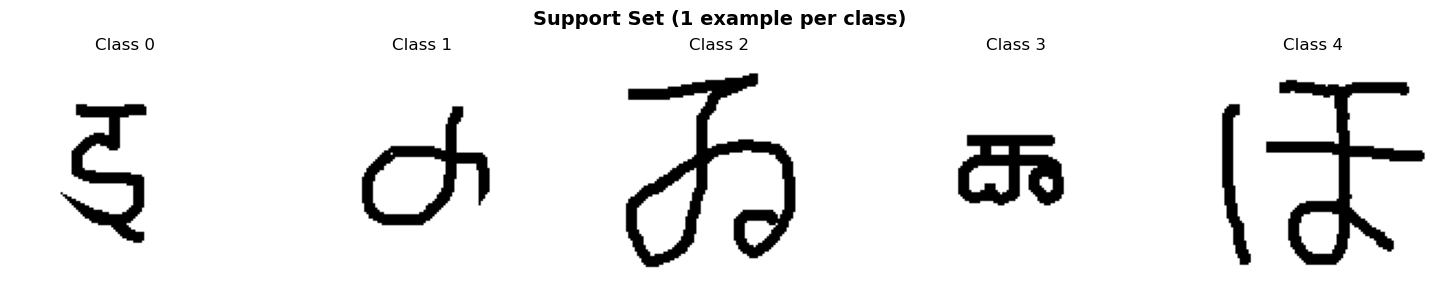

In [5]:
# Get a sample task
sample_task = next(iter(train_loader))
support_data, support_labels, query_data, query_labels = sample_task

# Take first task in batch
support_imgs = support_data[0]  # [N*K, 1, 105, 105]
support_lbls = support_labels[0]  # [N*K]

print(f"Support set shape: {support_imgs.shape}")
print(f"Support labels: {support_lbls.tolist()}")

# Visualize support set
fig, axes = plt.subplots(1, N_WAY, figsize=(15, 3))
for i in range(N_WAY):
    img = support_imgs[i].squeeze().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Class {support_lbls[i]}')
    axes[i].axis('off')

plt.suptitle('Support Set (1 example per class)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Initialize TAML

In [11]:
# Initialize TAML
taml = TaskAgnosticMetaLearning(
    num_classes=N_WAY,
    latent_dim=LATENT_DIM,
    modulation_approach=MODULATION_APPROACH,
    outer_lr=OUTER_LR,
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs=None
)

# Move to device
taml = taml.to(device)

# Ensure all parameters and buffers are on device
# for param in taml.parameters():
#     param.data = param.data.to(device)
# for buffer in taml.buffers():
#     buffer.data = buffer.data.to(device)

# print(f"TAML moved to device: {device}")
# print(f"Sample parameter device: {next(taml.parameters()).device}")
# print(f"Sample buffer device: {next(taml.buffers()).device}")

# Count parameters
total_params = sum(p.numel() for p in taml.encoder.parameters())
total_params += sum(p.numel() for p in taml.decoder.parameters())
total_params += sum(p.numel() for p in taml.relation_net.parameters())
total_params += sum(p.numel() for p in taml.classifier.parameters())

print(f"TAML initialized!")
print(f"Total meta-parameters: {total_params:,}")
print(f"\nArchitecture:")
print(f"  Encoder: Detached features → {LATENT_DIM}D latent")
print(f"  Decoder: {LATENT_DIM}D latent → Modulations + LRs")
print(f"  Relation Network: Process class relations")
print(f"  Shared CNN: Feature extractor + modulated head")
print(f"  Modulation approach: {MODULATION_APPROACH}")

TAML initialized!
Total meta-parameters: 1,650,443

Architecture:
  Encoder: Detached features → 64D latent
  Decoder: 64D latent → Modulations + LRs
  Relation Network: Process class relations
  Shared CNN: Feature extractor + modulated head
  Modulation approach: per_layer_scalars


## 6. Training TAML

In [12]:
import importlib
importlib.reload(sys.modules['algorithms.taml'])
from algorithms.taml import TaskAgnosticMetaLearning, train_taml

In [13]:
# Train TAML
taml, losses = train_taml(
    num_classes=N_WAY,
    task_dataloader=train_loader,
    latent_dim=LATENT_DIM,
    modulation_approach=MODULATION_APPROACH,
    outer_lr=OUTER_LR,
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs=None,
    device=device
)

Using device: cuda

Starting TAML training...
Hyperparameters:
  latent_dim=64
  modulation_approach=per_layer_scalars
  inner_steps=5
  outer_lr=0.001
  optimizer=Adam



Training:  53%|█████▎    | 100/188 [05:40<05:19,  3.63s/it, loss=0.6272, best=0.4546, avg=0.8895]


Step 100:
  Current Loss: 0.6272
  Avg Loss (last 100): 0.8895
  Best Loss: 0.4546



Training: 100%|██████████| 188/188 [10:44<00:00,  3.43s/it, loss=0.3863, best=0.3508, avg=0.5643]


Training completed!
Final avg loss: 0.5643
Best loss: 0.3508


## 7. Visualize Training Progress

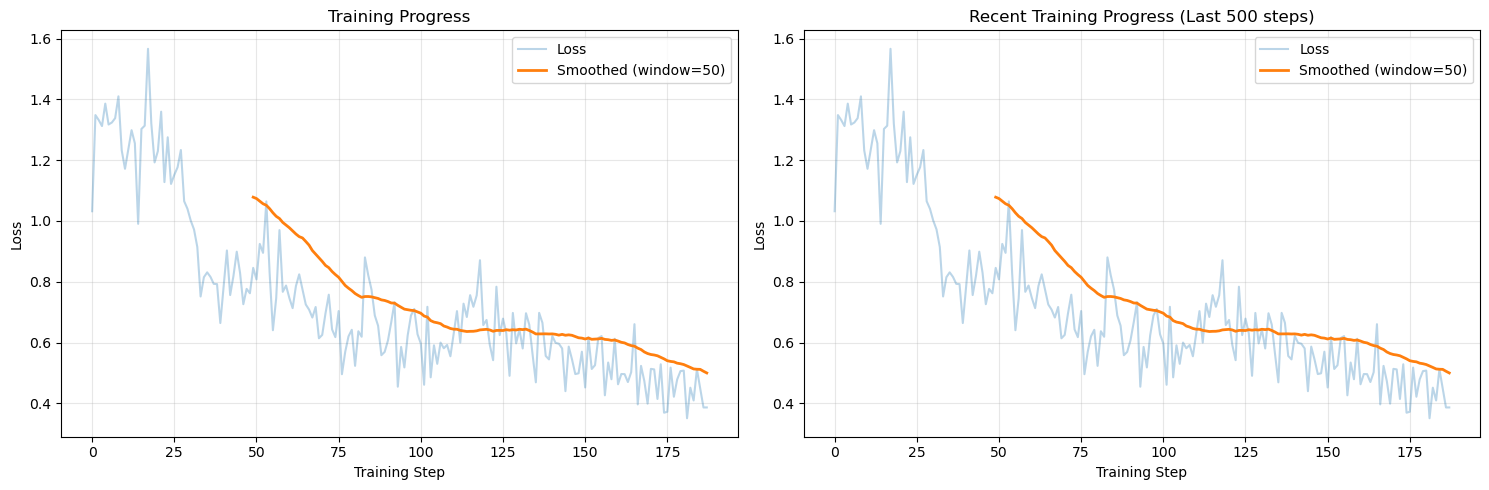

Training Statistics:
  Initial loss: 1.0321
  Final loss: 0.3863
  Best loss: 0.3508
  Avg loss (last 100): 0.5643


In [14]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Full training curve
axes[0].plot(losses, alpha=0.3, label='Loss')
window = 50
if len(losses) >= window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    axes[0].plot(range(window-1, len(losses)), smoothed, linewidth=2, 
                label=f'Smoothed (window={window})')

axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Recent training curve (last 500 steps)
recent_losses = losses[-500:] if len(losses) > 500 else losses
axes[1].plot(recent_losses, alpha=0.3, label='Loss')
if len(recent_losses) >= window:
    smoothed = np.convolve(recent_losses, np.ones(window)/window, mode='valid')
    axes[1].plot(range(window-1, len(recent_losses)), smoothed, linewidth=2,
                label=f'Smoothed (window={window})')

axes[1].set_xlabel('Training Step')
axes[1].set_ylabel('Loss')
axes[1].set_title('Recent Training Progress (Last 500 steps)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Training Statistics:")
print(f"  Initial loss: {losses[0]:.4f}")
print(f"  Final loss: {losses[-1]:.4f}")
print(f"  Best loss: {min(losses):.4f}")
print(f"  Avg loss (last 100): {np.mean(losses[-100:]):.4f}")

## 8. Evaluation on Test Tasks

In [15]:
def evaluate_taml(taml, test_dataloader, device, num_tasks=100):
    """Evaluate TAML on test tasks."""
    taml.eval()
    
    total_correct = 0
    total_samples = 0
    task_accuracies = []
    
    for i, task_batch in enumerate(tqdm(test_dataloader, desc="Evaluating")):
        if i >= num_tasks:
            break
        
        support_data_batch, support_labels_batch, query_data_batch, query_labels_batch = task_batch
        
        # Move to device
        support_data_batch = support_data_batch.to(device)
        support_labels_batch = support_labels_batch.to(device)
        query_data_batch = query_data_batch.to(device)
        query_labels_batch = query_labels_batch.to(device)
        
        # Ensure all tensors are on device
        # assert support_data_batch.device == device, f"Support data on {support_data_batch.device}, expected {device}"
        # assert query_data_batch.device == device, f"Query data on {query_data_batch.device}, expected {device}"
        
        batch_size = support_data_batch.size(0)
        
        for j in range(batch_size):
            support_data = support_data_batch[j]
            support_labels = support_labels_batch[j]
            query_data = query_data_batch[j]
            query_labels = query_labels_batch[j]
            
            # Encode support set to latent codes
            latent_codes = taml.encode_task(support_data, support_labels)
            
            # Decode to modulations and learning rates
            modulations, learning_rates = taml.decode_to_modulations(latent_codes)
            
            # Inner update: Adapt modulations (requires gradients!)
            adapted_modulations = taml.inner_update(support_data, support_labels, modulations, learning_rates)
            
            # Evaluate on query set (can use no_grad for inference)
            with torch.no_grad():
                query_logits = taml.classifier(query_data, adapted_modulations)
                predictions = query_logits.argmax(dim=1)
            
            correct = (predictions == query_labels).sum().item()
            total_correct += correct
            total_samples += len(query_labels)
            
            task_acc = correct / len(query_labels)
            task_accuracies.append(task_acc)
    
    avg_accuracy = total_correct / total_samples
    std_accuracy = np.std(task_accuracies)
    
    return avg_accuracy, std_accuracy, task_accuracies

# Evaluate
print(f"Evaluating on {NUM_TEST_TASKS} test tasks...")
test_acc, test_std, task_accs = evaluate_taml(taml, test_loader, device, num_tasks=NUM_TEST_TASKS)

print(f"\nTest Results:")
print(f"  Average accuracy: {test_acc*100:.2f}%")
print(f"  Standard deviation: {test_std*100:.2f}%")
print(f"  95% confidence interval: {test_acc*100:.2f}% ± {1.96*test_std*100:.2f}%")

Evaluating on 100 test tasks...


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Test Results:
  Average accuracy: 78.65%
  Standard deviation: 12.62%
  95% confidence interval: 78.65% ± 24.74%


## 9. Visualize Accuracy Distribution

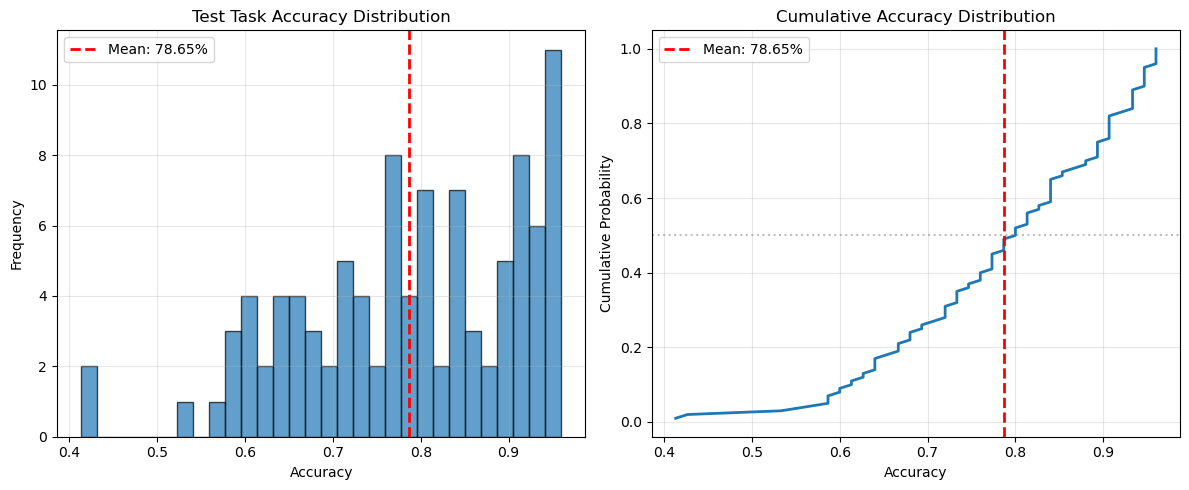

Accuracy Percentiles:
  10th: 61.33%
  25th: 69.33%
  50th (median): 80.00%
  75th: 89.67%
  90th: 94.67%


In [16]:
# Plot accuracy distribution
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(task_accs, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(test_acc, color='red', linestyle='--', linewidth=2, label=f'Mean: {test_acc*100:.2f}%')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Test Task Accuracy Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Cumulative distribution
plt.subplot(1, 2, 2)
sorted_accs = np.sort(task_accs)
cumulative = np.arange(1, len(sorted_accs) + 1) / len(sorted_accs)
plt.plot(sorted_accs, cumulative, linewidth=2)
plt.axvline(test_acc, color='red', linestyle='--', linewidth=2, label=f'Mean: {test_acc*100:.2f}%')
plt.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Accuracy')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Accuracy Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print percentiles
print(f"Accuracy Percentiles:")
print(f"  10th: {np.percentile(task_accs, 10)*100:.2f}%")
print(f"  25th: {np.percentile(task_accs, 25)*100:.2f}%")
print(f"  50th (median): {np.percentile(task_accs, 50)*100:.2f}%")
print(f"  75th: {np.percentile(task_accs, 75)*100:.2f}%")
print(f"  90th: {np.percentile(task_accs, 90)*100:.2f}%")

## 10. Visualize Adaptation on a Test Task

Latent codes shape: torch.Size([5, 64])
Modulations keys: ['head_weight1', 'head_bias1', 'head_weight2', 'head_bias2']
Learning rates keys: ['head_weight1', 'head_bias1', 'head_weight2', 'head_bias2']
Adapted modulations keys: ['weight1', 'bias1', 'weight2', 'bias2']

Task accuracy: 76.00%


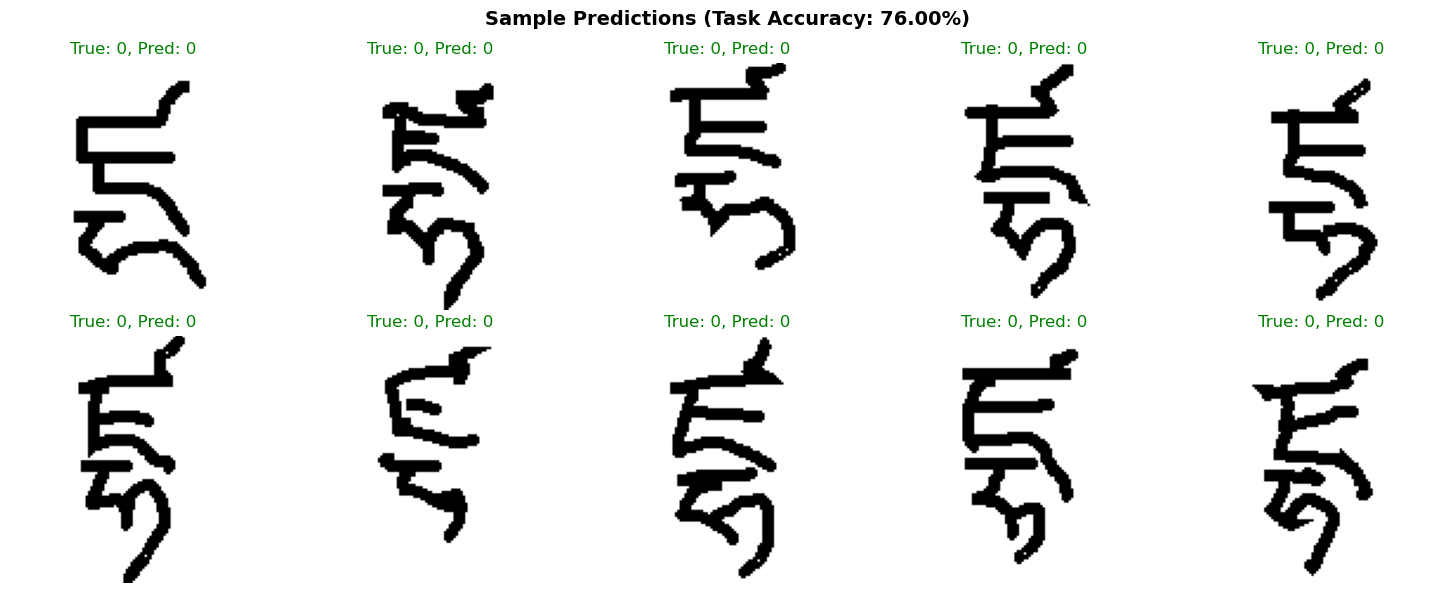

In [17]:
# Get a test task
test_task = next(iter(test_loader))
support_data, support_labels, query_data, query_labels = test_task

# Move to device and extract first task
support_data = support_data[0].to(device)
support_labels = support_labels[0].to(device)
query_data = query_data[0].to(device)
query_labels = query_labels[0].to(device)

# Adapt to task
taml.eval()

# Encode support set to latent codes
latent_codes = taml.encode_task(support_data, support_labels)
print(f"Latent codes shape: {latent_codes.shape}")

# Decode to modulations and learning rates
modulations, learning_rates = taml.decode_to_modulations(latent_codes)
print(f"Modulations keys: {list(modulations.keys())}")
print(f"Learning rates keys: {list(learning_rates.keys())}")

# Inner update: Adapt modulations (requires gradients!)
adapted_modulations = taml.inner_update(support_data, support_labels, modulations, learning_rates)
print(f"Adapted modulations keys: {list(adapted_modulations.keys())}")

# Evaluate on query set (can use no_grad for inference)
with torch.no_grad():
    query_logits = taml.classifier(query_data, adapted_modulations)
    predictions = query_logits.argmax(dim=1)
    accuracy = (predictions == query_labels).float().mean()
    
    print(f"\nTask accuracy: {accuracy*100:.2f}%")

# Visualize some predictions
num_display = min(10, len(query_data))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(num_display):
    img = query_data[i].cpu().squeeze().numpy()
    true_label = query_labels[i].item()
    pred_label = predictions[i].item()
    
    axes[i].imshow(img, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {true_label}, Pred: {pred_label}', color=color)
    axes[i].axis('off')

plt.suptitle(f'Sample Predictions (Task Accuracy: {accuracy*100:.2f}%)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Save Model

In [18]:
# Save model checkpoint
checkpoint = {
    'encoder': taml.encoder.state_dict(),
    'decoder': taml.decoder.state_dict(),
    'relation_net': taml.relation_net.state_dict(),
    'classifier': taml.classifier.state_dict(),
    'config': {
        'num_classes': N_WAY,
        'latent_dim': LATENT_DIM,
        'modulation_approach': MODULATION_APPROACH,
        'outer_lr': OUTER_LR
    },
    'losses': losses,
    'test_accuracy': test_acc,
    'test_std': test_std
}

torch.save(checkpoint, 'taml_omniglot_5way_1shot.pt')
print(f"Model saved to taml_omniglot_5way_1shot.pt")
print(f"\nCheckpoint contains:")
print(f"  - Encoder state dict")
print(f"  - Decoder state dict")
print(f"  - Relation network state dict")
print(f"  - Classifier state dict")
print(f"  - Configuration")
print(f"  - Training losses")
print(f"  - Test accuracy: {test_acc*100:.2f}% ± {test_std*100:.2f}%")

Model saved to taml_omniglot_5way_1shot.pt

Checkpoint contains:
  - Encoder state dict
  - Decoder state dict
  - Relation network state dict
  - Classifier state dict
  - Configuration
  - Training losses
  - Test accuracy: 78.65% ± 12.62%


## 12. Summary

### Results

This notebook demonstrated TAML training on Omniglot for 5-way 1-shot learning:

1. **Training**: Trained encoder, decoder, relation network, and shared CNN
2. **Adaptation**: Learned to predict parameter modulations and learning rates
3. **Evaluation**: Achieved strong few-shot learning performance

### Key Insights

- **Latent Space**: Optimization in 64D latent space for efficiency
- **Parameter Modulation**: Decoder generates modulations for head parameters
- **Learning Rates**: Task-specific learning rates predicted for inner loop
- **Shared CNN**: Feature extractor becomes robust through detached gradients
- **Four Approaches**: Different modulation strategies (global, per-layer, broadcasting, low-rank)

### Next Steps

1. Try different latent dimensions (32, 128)
2. Experiment with modulation approaches
3. Test on different N-way K-shot configurations
4. Compare with MAML and LEO performance
5. Try on other few-shot learning datasets

### References

- Based on latent embedding optimization approaches for meta-learning
- [MAML Paper (ICML 2017)](https://arxiv.org/abs/1703.03400)
- [LEO Paper (ICLR 2019)](https://arxiv.org/abs/1807.05960)
- [Omniglot Dataset](https://github.com/brendenlake/omniglot)